Overview of Oligo subclusters
----

- Leiden clustering
- Composition of data (AD vs Ctrl, Cortex areas counts)
- Cluster stability with Cluster tree

Return: 
- `adata_oligo_final.h5ad` with `leiden_merged` for DGE testing
- `.csv` files for DESea analysis in R

## Dependecy notebooks

`08_data_overview.ipynb`: The data needs to be fully preprocessed, integrated and cell types annotated. 

## Import packages

If you want modules to be automatically reloaded when you call them, use `autoreload`:

In [1]:
%load_ext autoreload
%autoreload 2

Import packages

In [8]:
# import standard packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
from pathlib import Path

# import single-cell packages
import scanpy as sc
import anndata as ad
# import scvi

# set verbosity levels
sc.settings.verbosity = 2

# ignore user warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

## Set up paths

Define global paths.

In [3]:
import sys

sys.path.insert(0, "../")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR_OLD, DATA_DIR, RESULTS_DIR, FIG_DIR
from colors import AREA_COLOR, CONDITION_COLOR, get_color, OLIGO_COLOR
from utils.analysis_utils import cluster_cells_by_gene_expression
from utils.marker_genes import amyloid_plaque_human

Set up the paths to save figures.

In [4]:
sc.settings.figdir = str(Path(FIG_DIR, 'oligo_analysis'))
#scv.settings.figdir = str(FIG_DIR)
#cr.settings.figdir = str(FIG_DIR)

## Set global parameters

Set some plotting parameters.

In [5]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['savefig.dpi'] = 300 # If 'figure', uses the figure's dpi value.
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
sc.settings.figdir

PosixPath('/ictstr01/home/icb/francesca.drummer/jaekel/ad_jaekel/figures/oligo_analysis')

If there are other global parameters for this analysis, put them here as well. 

## Define utility functions

Any utility functions you may need in this notebook go here. 

In [9]:
from utils.utils import SAMPLES, VERSION

In [8]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [9]:
def cluster_cells_by_gene_expression(adata: ad.AnnData, threshold: float, gene_name: str = "MT-ND4") -> None:
    """
    Clusters cells in the AnnData object based on gene expression threshold.
    
    Parameters:
        adata (AnnData): The input AnnData object containing cell data.
        threshold (float): The expression threshold for clustering.
        gene_name (str): The name of the gene used for clustering. Default is "MT-ND4".
        
    Returns:
        None: The function updates `adata.obs` with a new column `MT_ND4_cluster`.
    """
    if gene_name not in adata.var_names:
        raise ValueError(f"Gene '{gene_name}' not found in `adata.var_names`.")
    
    # Get the expression values for MT-ND4
    gene_expression = adata[:, gene_name].X.toarray().flatten() if hasattr(adata[:, gene_name].X, 'toarray') else adata[:, gene_name].X
    
    # Cluster cells based on the threshold
    clusters = np.where(gene_expression >= threshold, "High", "Low")
    
    # Add the cluster information to `adata.obs`
    adata.obs[f"{gene_name}_cluster"] = clusters

    return adata

## Load the data

In [10]:
adata_oligo = sc.read_h5ad(Path(DATA_DIR / f"{VERSION}_adata_oligo_subset.h5ad"))
adata_oligo

AnnData object with n_obs × n_vars = 9030 × 34802
    obs: 'sample', 'condition', 'area', 'age', 'donor', 'sequencing batch', 'sequencing id', 'sex', 'APOE genotype', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear', 'braak_stage', 'area_abbrev', 'condition_area', 'brainbank', 'brain_area_latin', 'soupx_groups', 'scDblFinder_score', 'scDblFinder_class', 'leiden', 'mt_groups', 'tech_sample_2', 'log1p_counts', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_2.0', 'celltype', 'cell_type', 'cell_type_sea', 'leiden_clean_up'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_

In [11]:
adata_oligo.obs.drop(columns=['leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_2.0', 'leiden_clean_up', 'celltype'], inplace=True)

In [12]:
del adata_oligo.var['highly_variable_nbatches'], adata_oligo.var['highly_variable_intersection'], adata_oligo.var['highly_variable']

### Overlap with old data clusters

In [75]:
old_adata_oligo = sc.read_h5ad("/lustre/groups/ml01/projects/2023_ad_jaekel/AD1_2022/AD1_adatas/april22_adata_sea_oligo.h5ad")
old_adata_oligo

AnnData object with n_obs × n_vars = 10001 × 18028
    obs: 'sample', 'condition', 'area', 'age', 'Braak stage', 'donor', 'sequencing batch', 'Brainbank source', 'sequencing id', 'sex', 'APOE genotype', 'brain area latin', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'tech_sample', 'n_counts_threshold', 'n_genes_threshold', 'is_doublet', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_2.0', 'celltype', 'cell_type_sea', 'leiden_scVI', 'leiden', 'condition+area', 'leiden_merged'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'area_colors', 'brain area latin_colors', 'cell_type_sea_colors', 'celltype_colors', 'condition_colors', 'leiden', 'leiden_colors', 'leiden_res_0.5_colors', 'leiden_res_1.0_colors', 'leiden_res_2.0_colors', 'leiden_scVI_colors', 'log1p', 'neighbors', 'pca', 'tech_sample_colors', 'umap'
    obsm: 'X_mde', 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    laye

In [76]:
cells_oligo = adata_oligo.obs.index
cells_oligo_old = old_adata_oligo.obs.index

common_cells = cells_oligo.intersection(cells_oligo_old)
print(f"Number of common cells: {len(common_cells)}")

Number of common cells: 8680


In [77]:
adata_oligo.obs['old_leiden'] = 'unannotated'

In [78]:
annotation_mapping = old_adata_oligo.obs['leiden_merged'].to_dict()

In [79]:
for cell in common_cells:
    adata_oligo.obs.loc[cell, 'old_leiden'] = annotation_mapping[cell]

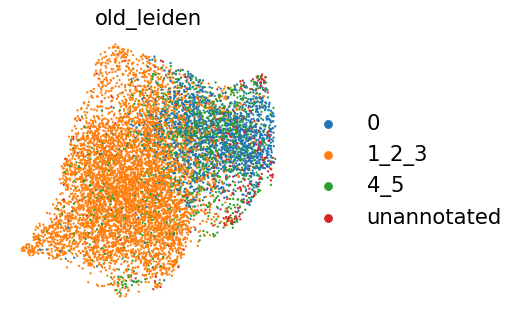

In [80]:
sc.pl.umap(
    adata_oligo, 
    color=['old_leiden'], 
    ncols=4, 
    frameon=False
)

## Leiden clustering

In [13]:
sc.pp.highly_variable_genes(adata_oligo, flavor='cell_ranger', n_top_genes = 5000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/differential-gene-expression/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:06)


In [14]:
sc.tl.pca(adata_oligo, use_highly_variable = True)
sc.pp.neighbors(adata_oligo, use_rep = 'X_scVI')
sc.tl.leiden(adata_oligo, resolution=0.5, key_added = 'leiden_oligo')
sc.tl.umap(adata_oligo)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)
computing neighbors
    finished (0:00:27)
running Leiden clustering
    finished (0:00:04)
computing UMAP
    finished (0:00:14)


/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/differential-gene-expression/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/differential-gene-expression/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/differential-gene-expression/

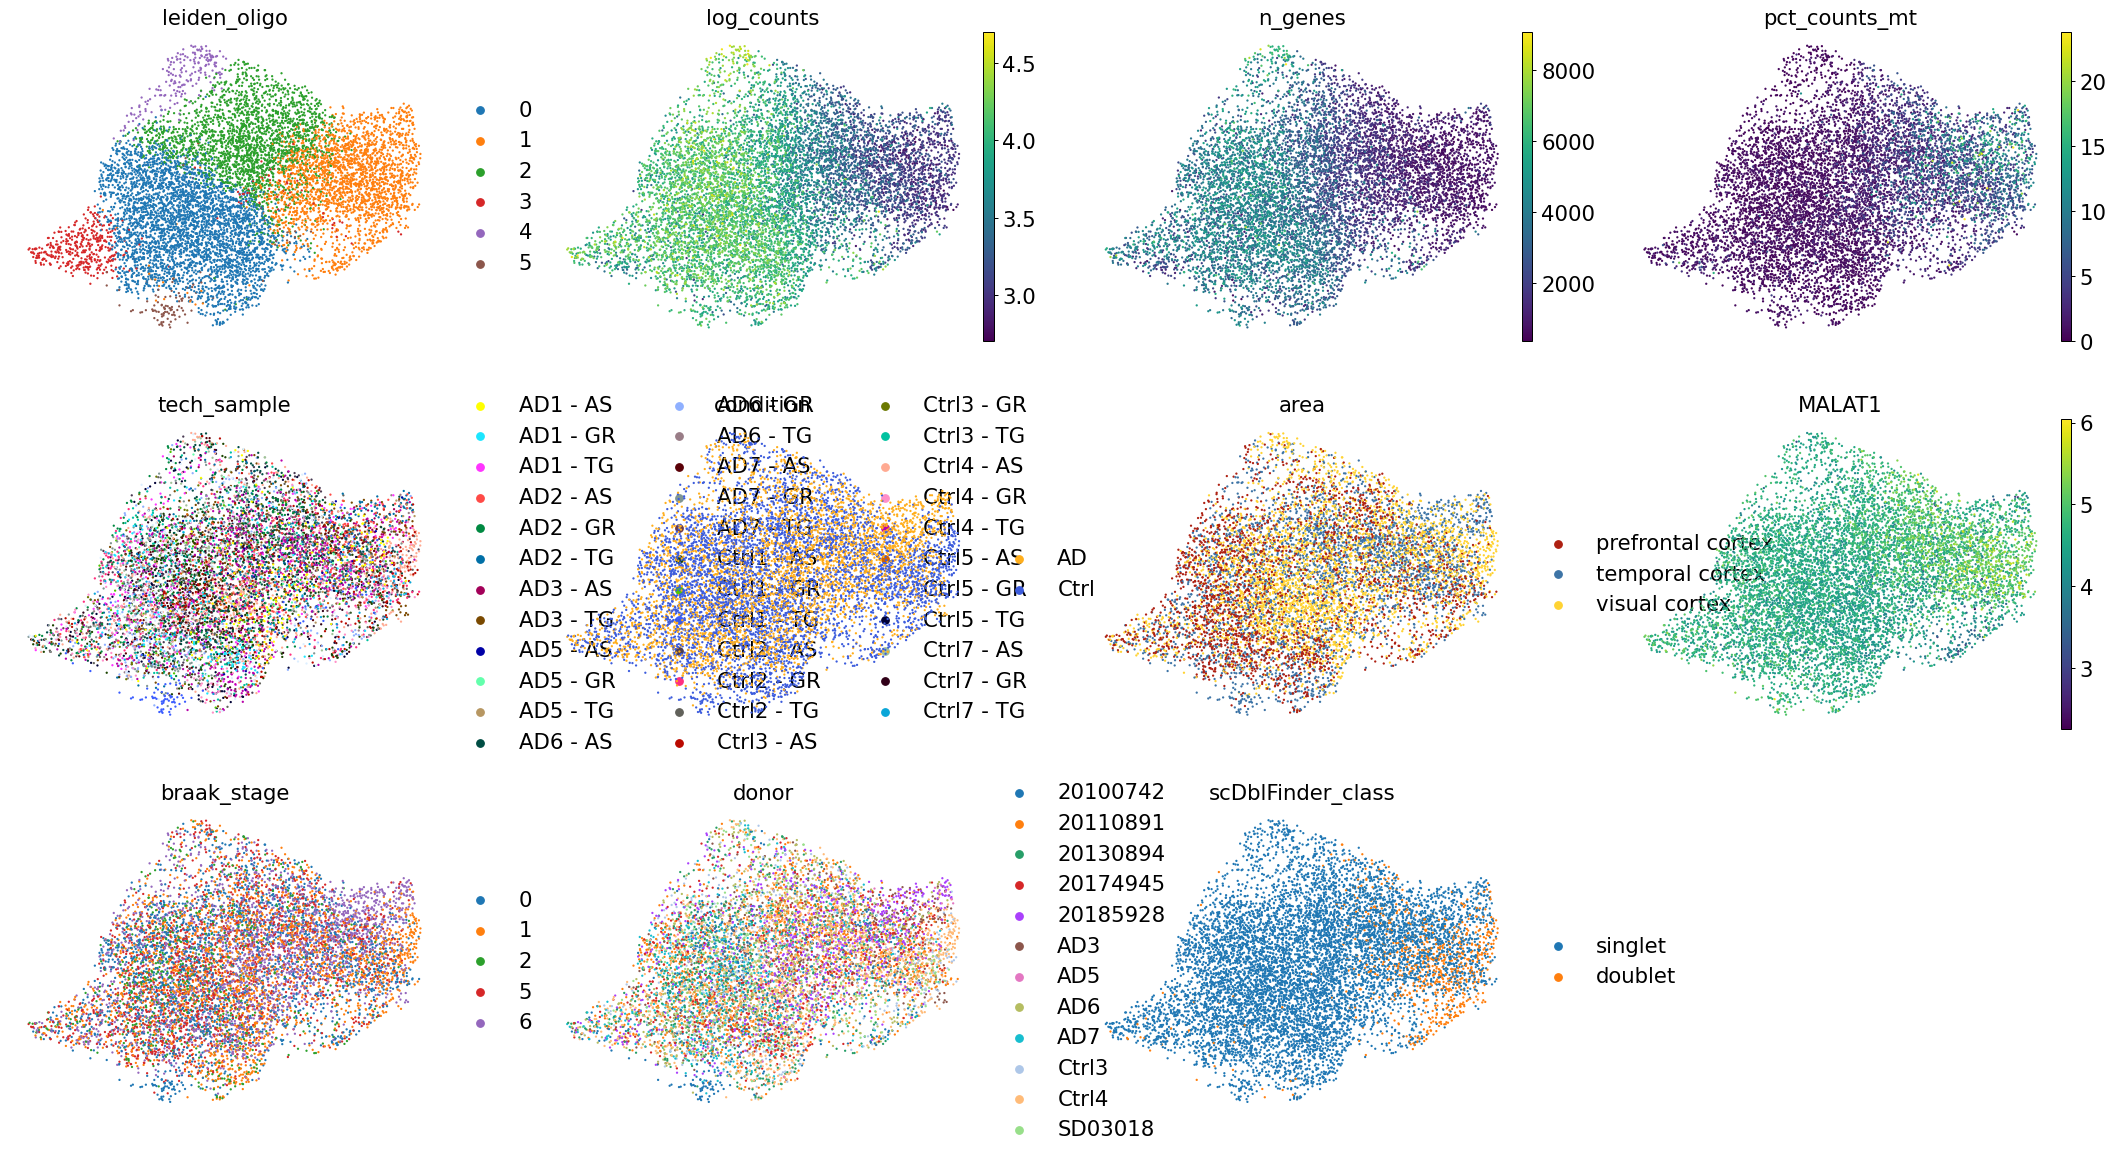

In [15]:
sc.pl.umap(
    adata_oligo, 
    color=['leiden_oligo', 'log_counts', 'n_genes', 'pct_counts_mt', 'tech_sample', 'condition', 'area', 'MALAT1', 'braak_stage', 'donor', 'scDblFinder_class'], 
    ncols=4, 
    frameon=False
)

In [16]:
adata_oligo.obs.leiden_oligo.value_counts(normalize=False)

leiden_oligo
0    3711
1    2296
2    2261
3     460
4     199
5     103
Name: count, dtype: int64

Remove cluster 5 because very few cells and mainly one donor.

In [17]:
adata_oligo = adata_oligo[adata_oligo.obs.leiden_oligo !='5']

### Data to pandas dataframe

For DESeq analysis in R: counts matrix must contain raw counts

In [18]:
merge_dict = {
    '0': '0',  
    '1': '1_2',  
    '2': '1_2',    
    '3': '3',  
    '4': '4',
}

adata_oligo.obs['leiden_merged'] = adata_oligo.obs['leiden_oligo'].map(merge_dict)

In [19]:
OLIGO_COLOR

['#B3E9AF', '#77C072', '#3FBF36', '#2F8F28', '#1A5016']

In [20]:
del adata_oligo.uns['leiden_merged_colors']

KeyError: 'leiden_merged_colors'

/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/differential-gene-expression/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


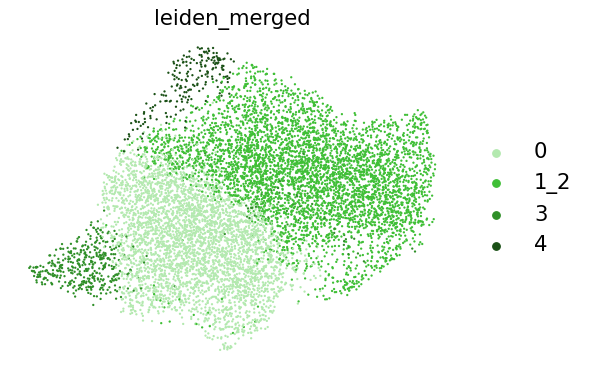

In [22]:
adata_oligo.uns['leiden_merged_colors'] = ['#B3E9AF', '#3FBF36', '#2F8F28',  '#1A5016']
sc.pl.umap(
    adata_oligo, 
    color=['leiden_merged'], 
    ncols=4, 
    frameon=False,
    save=f'_oligo_sub_clusters.png'
)

In [23]:
adata_oligo.obs.leiden_merged.value_counts(normalize=False)

leiden_merged
1_2    4557
0      3711
3       460
4       199
Name: count, dtype: int64

In [24]:
print(adata_oligo.layers['matrix'].max())

1380.0


### Export data as .csv

In [40]:
# Export the counts matrix to a CSV file
df_counts = pd.DataFrame(adata_oligo.layers['matrix'].toarray(), index=adata_oligo.obs_names, columns=adata_oligo.var_names)
df_counts.to_csv(Path(DATA_DIR / f"{VERSION}_counts_matrix_sea_oligo.csv"))

In [41]:
Path(DATA_DIR / f"{VERSION}_counts_matrix_sea_oligo.csv")

PosixPath('/lustre/groups/ml01/projects/2023_ad_jaekel/AD1_2025/adatas/april22_counts_matrix_sea_oligo.csv')

In [42]:
# Export metadata to CSV file
adata_oligo.obs.to_csv(Path(DATA_DIR / f"{VERSION}_metadata_sea_oligo.csv"))

In [43]:
Path(DATA_DIR / f"{VERSION}_metadata_sea_oligo.csv")

PosixPath('/lustre/groups/ml01/projects/2023_ad_jaekel/AD1_2025/adatas/april22_metadata_sea_oligo.csv')

### Save adata with oligo subclusters

In [25]:
adata_oligo.write(Path(DATA_DIR / f"{VERSION}_adata_oligo_final.h5ad"))

## Load final Oligo data

In [31]:
adata_oligo = sc.read_h5ad(Path(DATA_DIR / f"{VERSION}_adata_oligo_final.h5ad"))

### Compositional analysis of covariates across clusters

In [26]:
data=(
        adata_oligo.obs[['condition_area', 'leiden_merged']]
        .groupby('condition_area')
        .value_counts(normalize=True)
        .to_frame().sort_index().reset_index()
        .rename(columns={'proportion': 'fraction'})
    )

/localscratch/francesca.drummer/ipykernel_3793622/118957125.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_oligo.obs[['condition_area', 'leiden_merged']]


/localscratch/francesca.drummer/ipykernel_3793622/2707695675.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_oligo.obs[['condition_area', 'leiden_merged']]


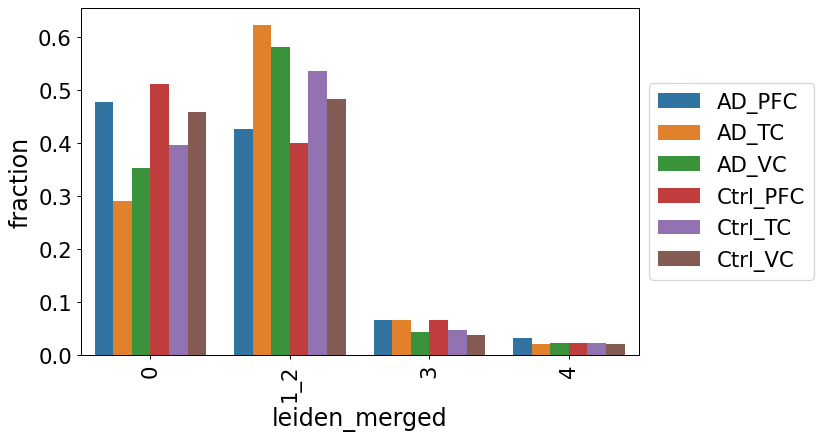

In [27]:
hue_order = [f'control - {cortex}' for cortex in AREA_COLOR.keys()] + [f'alzheimer - {cortex}' for cortex in AREA_COLOR.keys()]

plt.rcParams["figure.figsize"] = (8, 5)

data=(
    adata_oligo.obs[['condition_area', 'leiden_merged']]
    .groupby('condition_area')
    .value_counts(normalize=True)
    .to_frame().sort_index().reset_index()
    .rename(columns={'proportion': 'fraction'})
)

ax = sns.barplot(
    hue='condition_area',
    y='fraction',
    x='leiden_merged',
    data = data,
    #palette=[get_color(cond_area) for cond_area in data['condition_area'].unique()],
    #hue_order = hue_order
)
ax.tick_params(axis='x', labelrotation=90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Analysis results: 

- Leiden cluster 2: overexpression of control temportal cortex

In [28]:
adata_oligo.obs.groupby('condition')['leiden_merged'].value_counts(normalize=True)

/localscratch/francesca.drummer/ipykernel_3793622/2747339803.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_oligo.obs.groupby('condition')['leiden_merged'].value_counts(normalize=True)


condition  leiden_merged
AD         1_2              0.551510
           0                0.366775
           3                0.057713
           4                0.024002
Ctrl       1_2              0.481318
           0                0.450469
           3                0.047135
           4                0.021077
Name: proportion, dtype: float64

/localscratch/francesca.drummer/ipykernel_3793622/4020450602.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_oligo.obs[['condition', 'leiden_merged']]


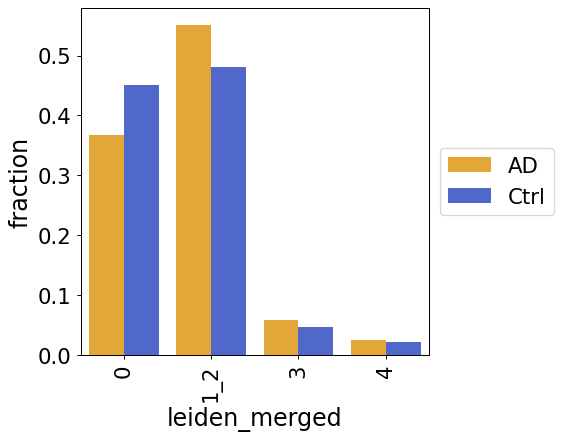

In [46]:
subset = ['AD', 'Ctrl']
palette = [CONDITION_COLOR[area] for area in subset]
sns.set_palette(palette)

plt.rcParams["figure.figsize"] = (5, 5)


data=(
    adata_oligo.obs[['condition', 'leiden_merged']]
    .groupby('condition')
    .value_counts(normalize=True)
    .to_frame().sort_index().reset_index()
    .rename(columns={'proportion': 'fraction'})
)

ax = sns.barplot(
    hue='condition',
    y='fraction',
    x='leiden_merged',
    data=data,
    #palette=[CONDITION_COLOR[cond] for cond in data['condition'].unique()],
    #hue_order = hue_order
)
ax.tick_params(axis='x', labelrotation=90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [30]:
adata_oligo.obs.groupby('area')['leiden_merged'].value_counts(normalize=True)

/localscratch/francesca.drummer/ipykernel_3793622/3935489990.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_oligo.obs.groupby('area')['leiden_merged'].value_counts(normalize=True)


area               leiden_merged
prefrontal cortex  0                0.495949
                   1_2              0.412793
                   3                0.065245
                   4                0.026013
temporal cortex    1_2              0.574109
                   0                0.349873
                   3                0.054707
                   4                0.021310
visual cortex      1_2              0.518906
                   0                0.421175
                   3                0.039267
                   4                0.020652
Name: proportion, dtype: float64

/localscratch/francesca.drummer/ipykernel_3793622/957761591.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_oligo.obs[['area', 'leiden_merged']]


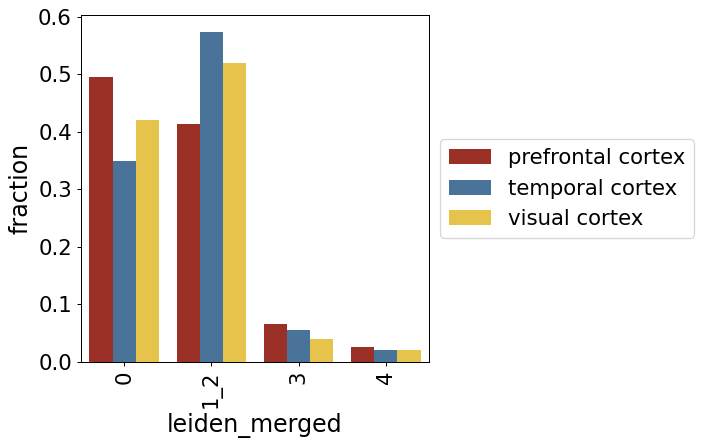

In [47]:
subset = ['PFC', 'TC', 'VC']
palette = [AREA_COLOR[area] for area in subset]
sns.set_palette(palette)

plt.rcParams["figure.figsize"] = (5, 5)

data=(
    adata_oligo.obs[['area', 'leiden_merged']]
    .groupby('area')
    .value_counts(normalize=True)
    .to_frame().sort_index().reset_index()
    .rename(columns={'proportion': 'fraction'})
)

ax = sns.barplot(
    hue='area',
    y='fraction',
    x='leiden_merged',
    #palette=[list(AREA_COLOR.values())],
    data=data
)
ax.tick_params(axis='x', labelrotation=90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [32]:
adata_oligo.obs.area.value_counts(normalize=True)

area
visual cortex        0.385124
temporal cortex      0.352190
prefrontal cortex    0.262686
Name: proportion, dtype: float64

In [33]:
adata_oligo.obs['condition_area'].value_counts(normalize=True)

condition_area
Ctrl_VC     0.247452
Ctrl_TC     0.197155
AD_TC       0.155035
Ctrl_PFC    0.140025
AD_VC       0.137672
AD_PFC      0.122662
Name: proportion, dtype: float64

In [34]:
adata_oligo.obs.condition.value_counts(normalize=True)

condition
Ctrl    0.584631
AD      0.415369
Name: proportion, dtype: float64

In [35]:
# ToDo: remove cluster 3 ???
adata_oligo.obs.leiden_oligo.value_counts(normalize=True)

leiden_oligo
0    0.415705
1    0.257197
2    0.253277
3    0.051529
4    0.022292
Name: proportion, dtype: float64

In [32]:
sc.tl.embedding_density(adata_oligo, basis='umap', groupby='condition')
sc.tl.embedding_density(adata_oligo, basis='umap', groupby='area')
sc.tl.embedding_density(adata_oligo, basis='umap', groupby='condition_area')

computing density on 'umap'
computing density on 'umap'
computing density on 'umap'


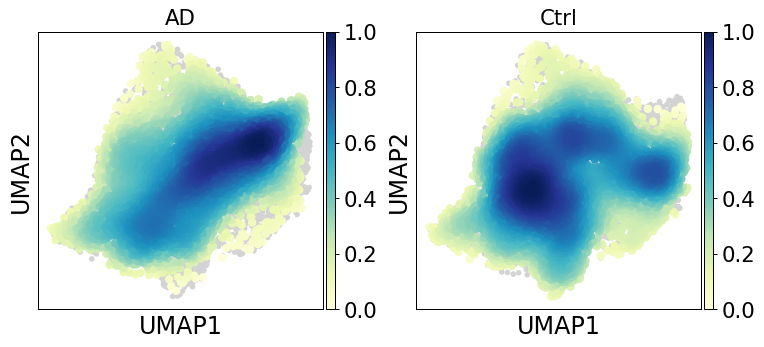

In [44]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.embedding_density(adata_oligo, basis='umap', key='umap_density_condition', color_map = "YlGnBu", save=f'oligo.png')

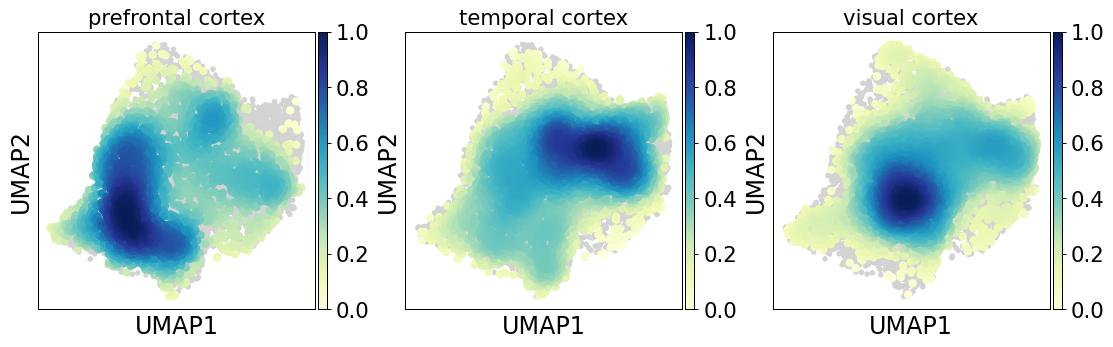

In [45]:
sc.pl.embedding_density(adata_oligo, basis='umap', key='umap_density_area', color_map = 'YlGnBu', save=f'oligo.png')

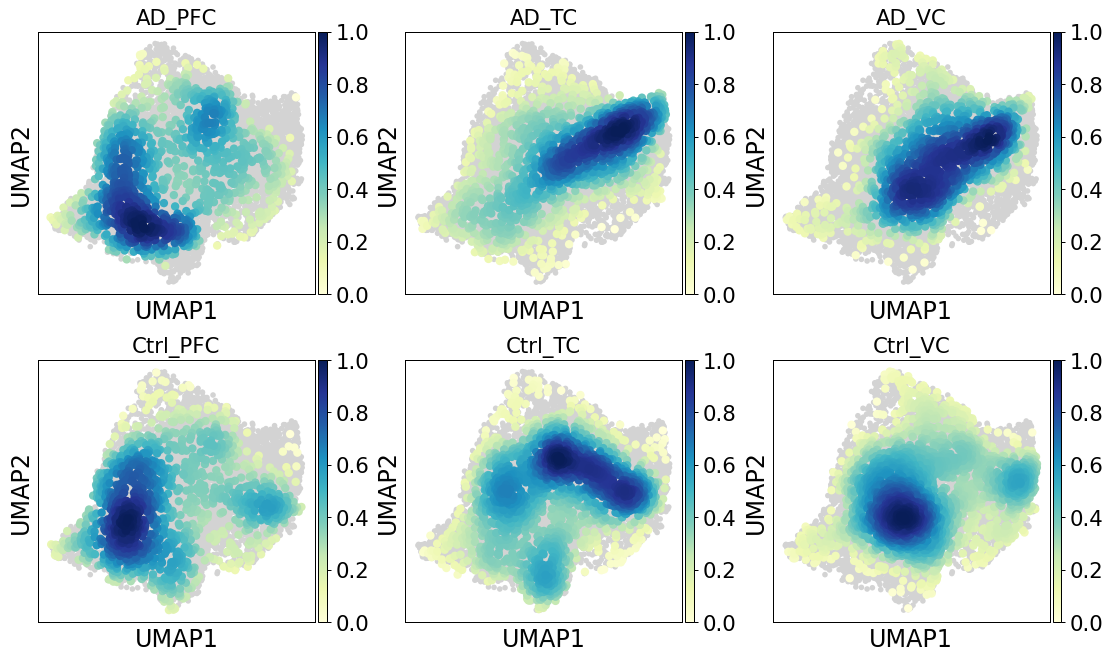

In [46]:
sc.pl.embedding_density(adata_oligo, basis='umap', key='umap_density_condition_area', color_map = 'YlGnBu', ncols=3, save=f'oligo.png')

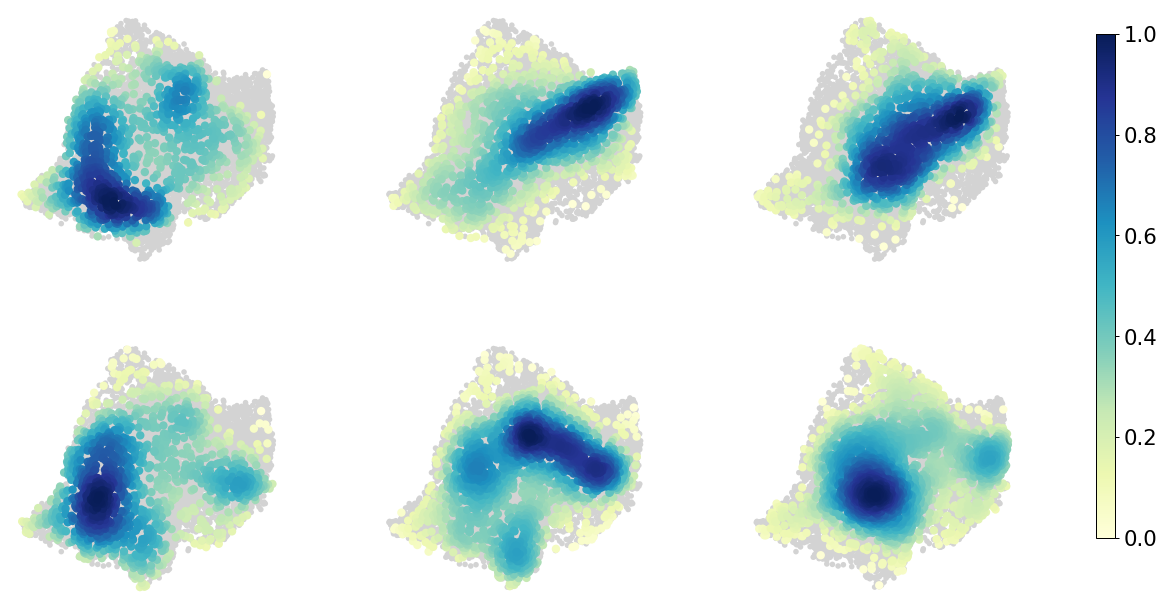

In [53]:
import matplotlib.pyplot as plt

# Create the plot
sc.pl.embedding_density(
    adata_oligo, 
    basis='umap', 
    key='umap_density_condition_area', 
    color_map='YlGnBu', 
    ncols=3,
    show=False
)

fig = plt.gcf()
axes = fig.get_axes()

# Identify and separate plot axes from colorbar axes
plot_axes = []
cbar_axes = []

for ax in axes:
    bbox = ax.get_position()
    aspect_ratio = bbox.width / bbox.height
    if aspect_ratio < 0.1:  # This is likely a colorbar
        cbar_axes.append(ax)
    else:
        plot_axes.append(ax)

# Remove all individual colorbars
for cbar_ax in cbar_axes:
    cbar_ax.remove()

# Clean up plot axes and remove outlines
for ax in plot_axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    # Remove all spines (outlines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Optionally remove ticks as well
    ax.set_xticks([])
    ax.set_yticks([])

# Add a single shared colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.90, 0.15, 0.015, 0.7])
sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)

plt.savefig(Path(FIG_DIR, 'oligo_analysis','umap_density_area_cond.png'), dpi=300, bbox_inches='tight')
plt.show()

### Disease associated oligo markers


In [13]:
disease_ass_markers = {
    "DAO TF" : ["SOCS3", "HOPX", "FOSB"],
    "DAO_ARO": ["SERPINA3",  "KLK6"],
    "GO_immune": ["STAT1", "B2M"],
    "GO cholesterol": ["FMO5", "FDFT1"],
}

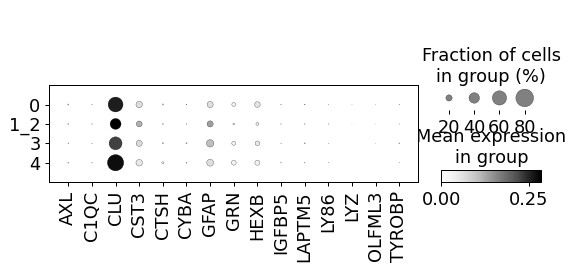

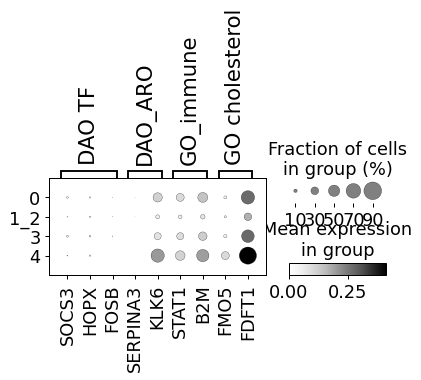

In [16]:
sc.pl.dotplot(adata_oligo, amyloid_plaque_human, groupby='leiden_merged', cmap = 'Greys', log = True, save='amyloid_plaque_dotplot_leiden.png')
sc.pl.dotplot(adata_oligo, disease_ass_markers, groupby='leiden_merged', cmap = 'Greys', log = True, save='dao_dotplot_leiden.png')

Is there a variation of DAO marker gene expression across patients?

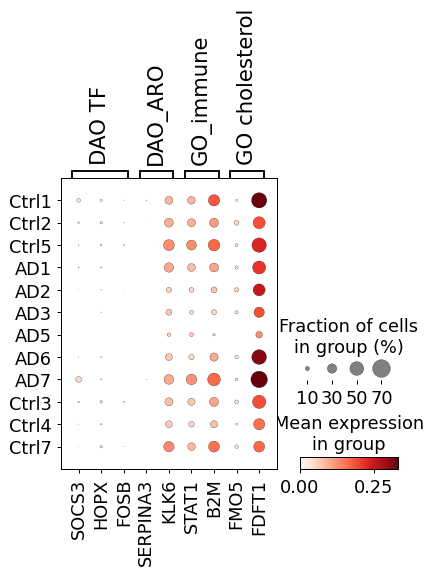

In [19]:
sc.pl.dotplot(adata_oligo, disease_ass_markers, groupby=['donor_v2'], log = True)

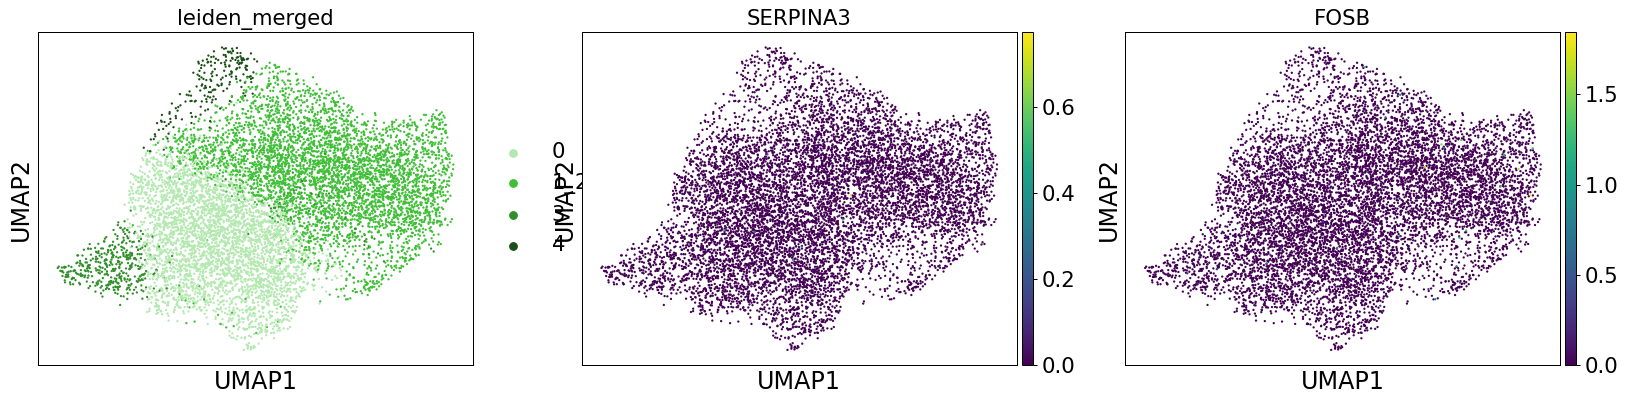

In [28]:
sc.pl.umap(
    adata_oligo,
    color=['leiden_merged', 'SERPINA3', 'FOSB'],
    save = '_dao_markers.png'
)

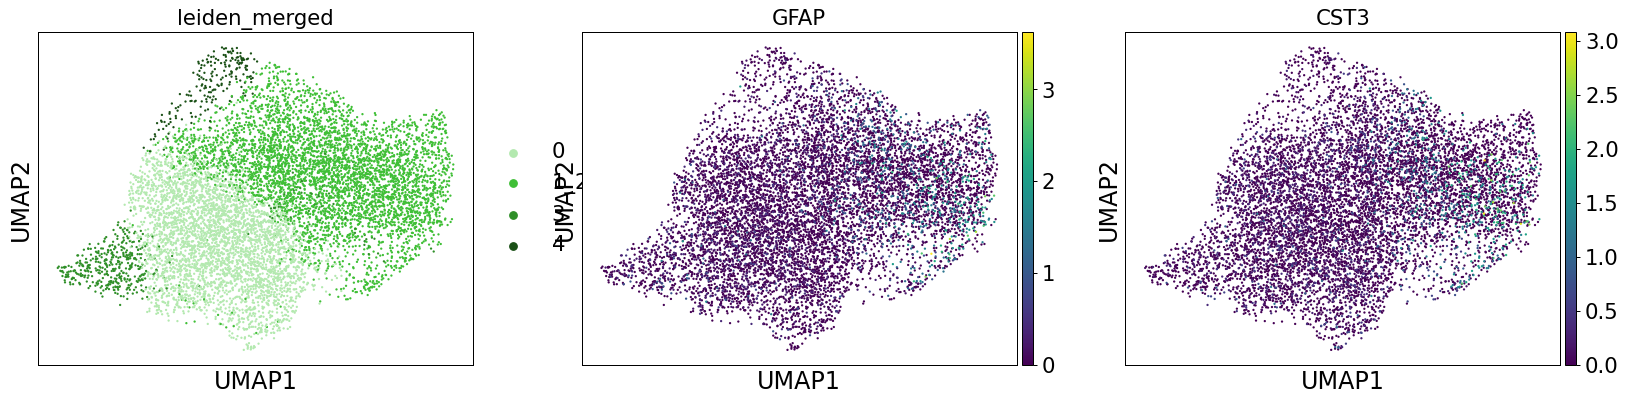

In [27]:
sc.pl.umap(
    adata_oligo,
    color=['leiden_merged', 'GFAP', 'CST3'],
    save = '_amyloid_markers.png'
)

In [48]:
adata_oligo = cluster_cells_by_gene_expression(adata_oligo, threshold = 1.5, gene_name = "SIRT2")

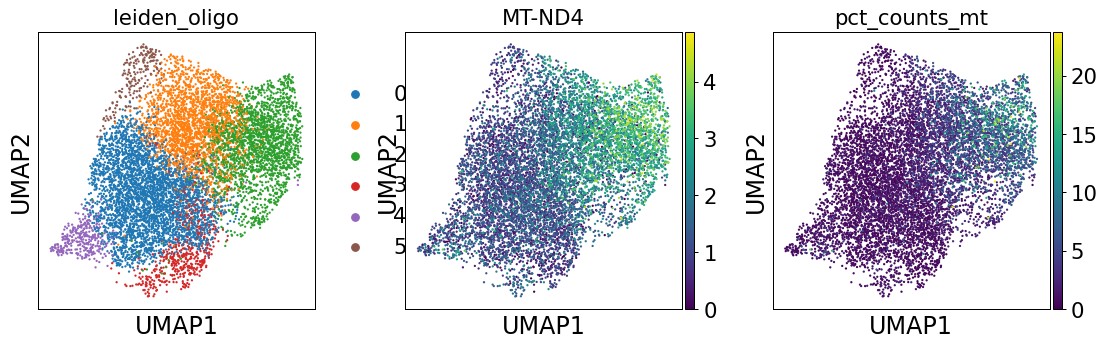

In [85]:
sc.pl.umap(
    adata_oligo,
    color=['leiden_oligo', 'MT-ND4', 'pct_counts_mt']
)

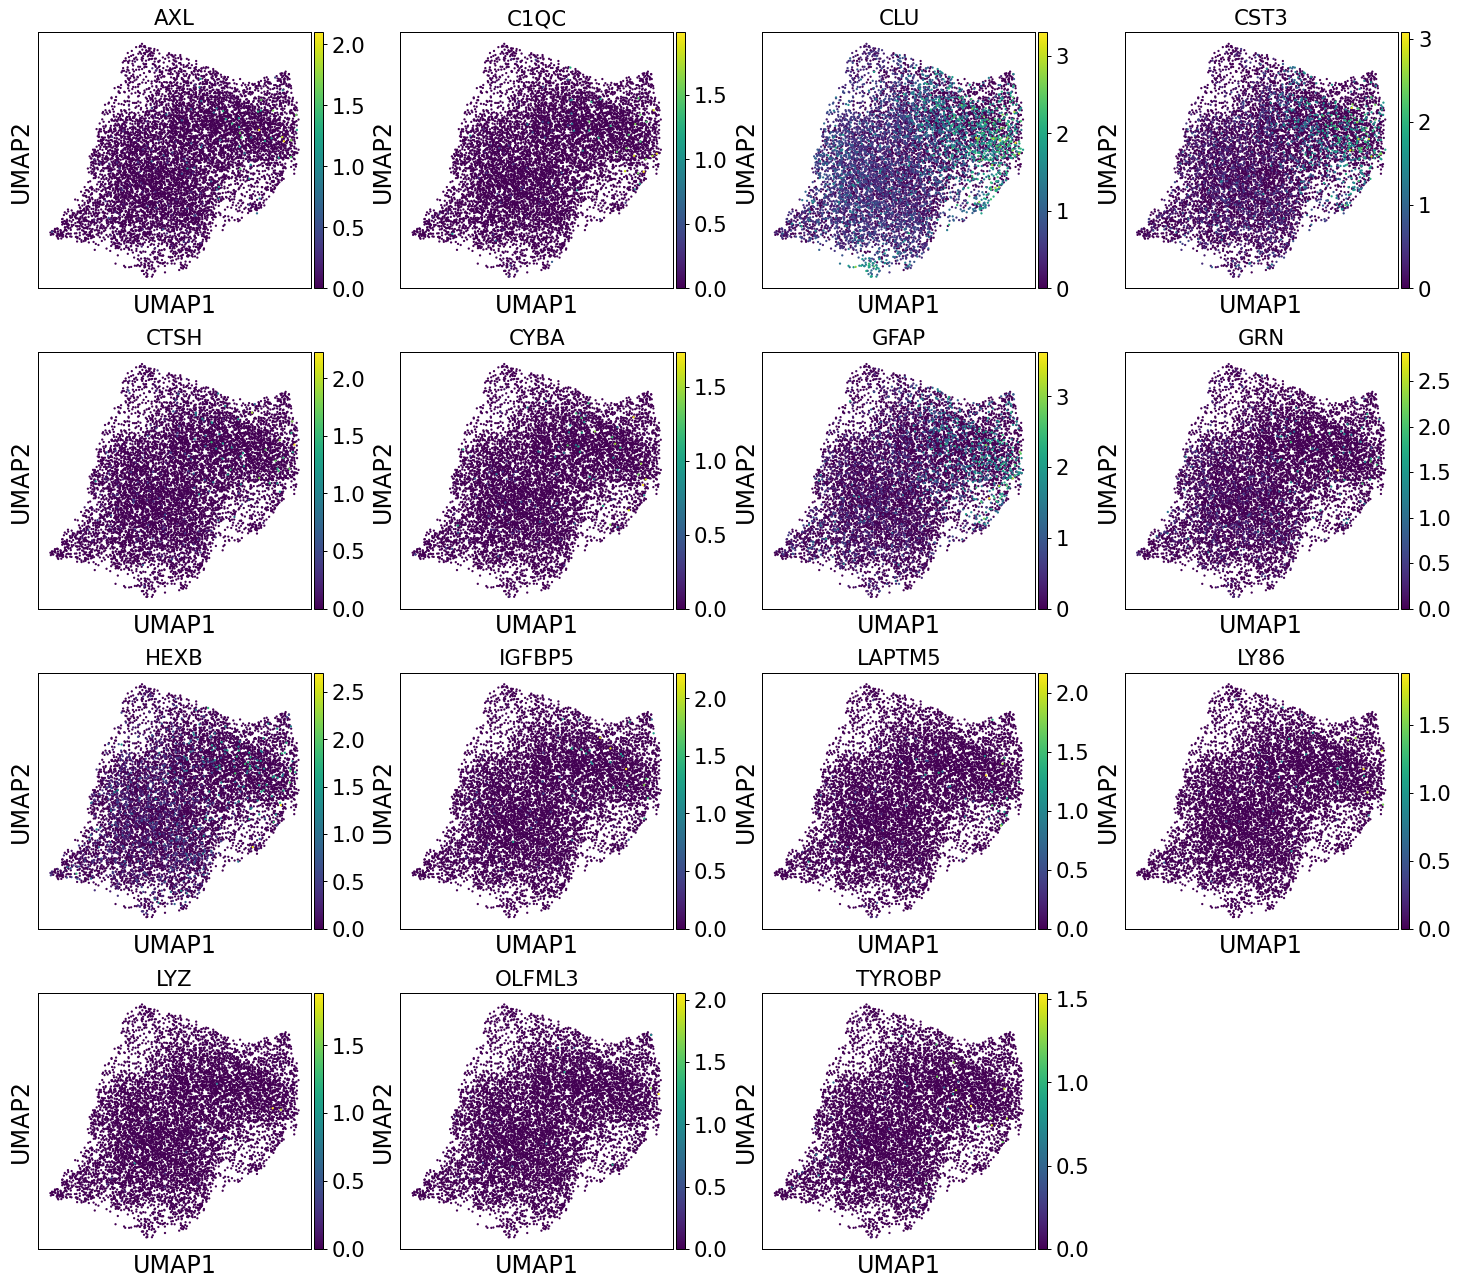

In [86]:
sc.pl.umap(
    adata_oligo,
    color=amyloid_plaque_human
)

In [119]:
nr_dge_genes = 50
sc.tl.rank_genes_groups(adata_oligo, groupby = 'MT-ND4_cluster', method = "wilcoxon")
for cluster in np.unique(adata_oligo.obs['MT-ND4_cluster']):
X    print("Leiden cluster: ", cluster)
    df = sc.get.rank_genes_groups_df(adata_oligo, group=cluster)
    print(df[:nr_dge_genes])
    print(df[-nr_dge_genes:])

ranking genes
    finished (0:00:19)
Leiden cluster:  High
              names     scores  logfoldchanges          pvals      pvals_adj
0            MT-ND4  29.311749        4.495982  7.347474e-189  2.558023e-184
1            MT-CO3  28.488941        4.185551  1.606002e-178  2.795649e-174
2           MT-ATP6  28.381060        4.695111  3.464320e-177  4.020344e-173
3            MT-CO2  28.272837        4.007086  7.458718e-176  6.491882e-172
4            MT-ND3  28.140511        4.387226  3.131079e-174  2.180171e-170
5            MT-ND2  27.826941        4.000171  2.048407e-170  1.188588e-166
6            MT-CYB  27.717602        4.263428  4.284551e-169  2.130952e-165
7            MT-ND1  27.314661        4.206738  2.840703e-164  1.236239e-160
8           MT-RNR2  26.837179        3.152923  1.190494e-158  4.605229e-155
9            MT-CO1  25.823256        3.305778  4.860808e-147  1.692290e-143
10          MT-RNR1  23.134594        2.602840  2.077828e-118  6.576326e-115
11           MT-N

## DESeq2 results

In [55]:
final_cluster_markers = {
    "Oligo markers": ["OLIG2", "PLP1", "CNP", "ST18", "GPR17", "OPALIN"],
    "Cluster 0": ["LAMA2", "LRP6", "ABCG1"],
    "Cluster 1_2": ['MT-ATP6', 'MT-CO1', 'MT-CO2', 'MT-ND1', 'MT-ND3', 'MT-ND4', "SYT1"],  # low in myelin genes
    "Cluster 3": ["FRY", "MDGA2", "KCNIP4", "GRIK2"],  # cellular signaling
    "Cluster 4": [
        "PIEZO2", "KLK6", "LDLRAD4", "RASGRF1", 
        "RBFOX1", "DHCR24", "FDFT1", "LSS"
    ]
}

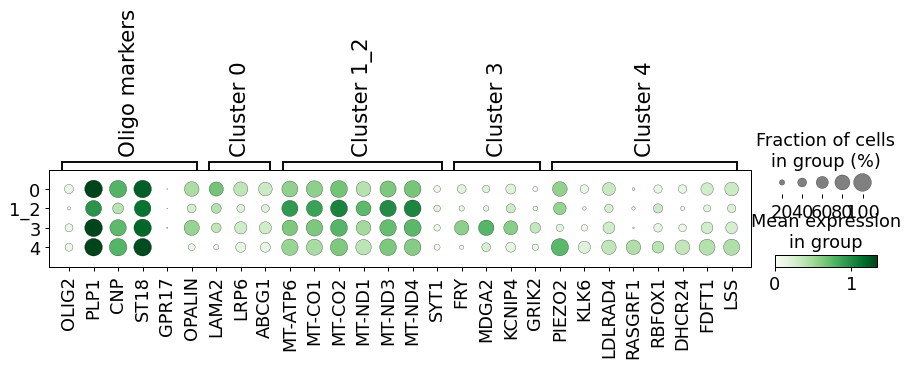

In [58]:
sc.pl.dotplot(adata_oligo, final_cluster_markers, groupby='leiden_merged', log = True, cmap = 'Greens', save='final_cluster_markers.png')

## Cluster stability

In [11]:
from pyclustree import clustree

In [12]:
resolutions = np.arange(0.1, 1.5, 0.2).round(1)
#resolutions = [0.1, 0.5, 1.0, 1.5, 2.0]
resolutions

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3])

In [13]:
# Run leiden clustering for different resolutions
for resolution in resolutions:
    sc.tl.leiden(
        adata_oligo,
        resolution=resolution,
        flavor="igraph",
        n_iterations=2,
        key_added=f"leiden_{str(resolution).replace('.', '_')}",
    )

running Leiden clustering
    finished (0:00:07)
running Leiden clustering
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)


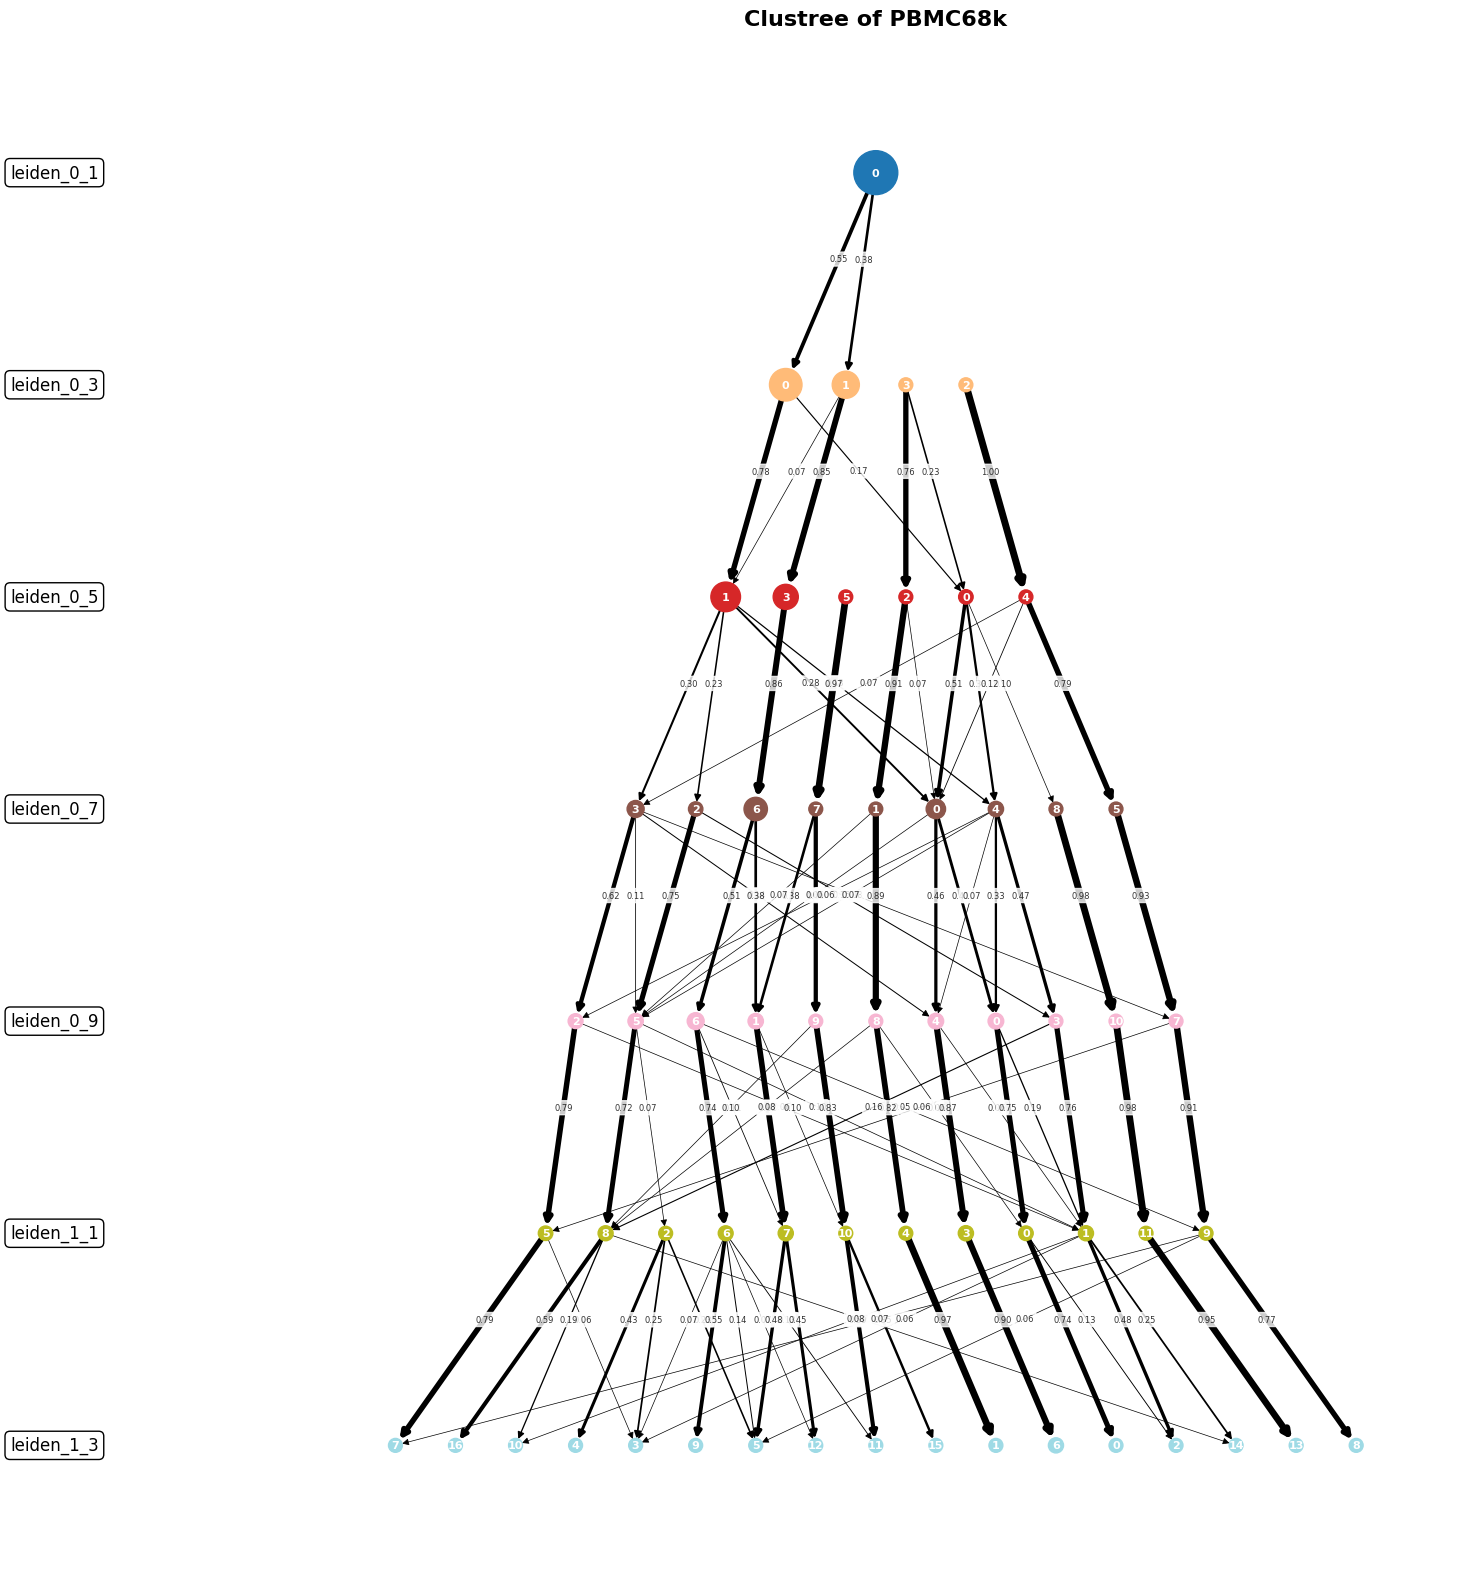

In [15]:
fig = clustree(
    adata_oligo,
    [f"leiden_{str(resolution).replace('.', '_')}" for resolution in resolutions],
    title="Clustree of PBMC68k",
    edge_weight_threshold=0.05,  # the minimum fraction of the parent cluster assigned to the child cluster to plot
    show_fraction=True,  # show the fraction of cells in each cluster
)
fig.set_size_inches(15, 20)
fig.set_dpi(100)